In [1]:
import torch
import torchvision
import torch.nn as nn
import torch.nn.functional as F
import torchvision.transforms as transforms
import os
import numpy as np
import cv2 as cv
import matplotlib.pyplot as plt
import csv

device = 'cuda:0' 

In [2]:
# BoostNet Dataset
# from SpineWeb dataset16
# link: http://spineweb.digitalimaginggroup.ca/spineweb/index.php?n=Main.Datasets

class BoostNetDataset(torch.utils.data.Dataset):
    def __init__(self, path, train=True):
        self.images = []
        self.labels = []
        
        if train:
            image_path = path + "/data/training/"
            names = csv.reader(open(path + "/labels/training/filenames.csv", 'r'))
            landmarks = csv.reader(open(path + "/labels/training/landmarks.csv", 'r'))
        else:
            image_path = path + "/data/test/"
            names = csv.reader(open(path + "/labels/test/filenames.csv", 'r'))
            landmarks = csv.reader(open(path + "/labels/test/landmarks.csv", 'r'))
        
        for landmark_each_image in landmarks:
            coordinate_list = []
            for coordinate in landmark_each_image:
                coordinate_list.append(float(coordinate))
            self.labels.append(torch.Tensor(coordinate_list))

        for i, name in enumerate(names):
            origin_image = cv.imread(image_path + name[0], cv.IMREAD_GRAYSCALE)
            
            target_height = 256
            target_width = 128
            image = np.zeros((target_height, target_width), np.uint8)
            cv.resize(origin_image, (target_width, target_height), image)
            
            image = np.reshape(image, (1, image.shape[0], image.shape[1]))
            image_tensor = torch.from_numpy(image).float()
            
            self.images.append(image_tensor)

        
    def __getitem__(self, index):
        image = self.images[index]
        label = self.labels[index]
        
        return image, label
    
    def __len__(self):
        return len(self.images)

In [3]:
# initialize the train and test data loader

train_data = BoostNetDataset("/disk2/jklu/dataset16/boostnet_labeldata", train=True)
test_data = BoostNetDataset("/disk2/jklu/dataset16/boostnet_labeldata", train=False)

batch = 4
train_loader = torch.utils.data.DataLoader(train_data, batch_size=batch,
                                         shuffle=True, num_workers=2)

test_loader = torch.utils.data.DataLoader(test_data, batch_size=batch,
                                         shuffle=True, num_workers=2)


print("number of batches(training): ", len(train_loader))
print("number of batches(testing): ",len(test_loader))

number of batches(training):  121
number of batches(testing):  32


In [4]:
# define network
class BoostNet(nn.Module):
    def __init__(self):
        super(BoostNet, self).__init__()
        
        # the first 4-parts convolutional layers in paper to extract features
        self.conv1 = nn.Conv2d(in_channels=1, out_channels=64, kernel_size=7, stride=1, padding=(1,2))
        self.pool1 = nn.MaxPool2d(kernel_size=3, stride=3)
        
        self.conv2 = nn.Conv2d(in_channels=64, out_channels=64, kernel_size=3, stride=1, padding=1)
        
        self.conv3 = nn.Conv2d(in_channels=64, out_channels=128, kernel_size=3, stride=1, padding=1)
        self.pool3 = nn.MaxPool2d(kernel_size=3, stride=3)
        
        self.conv4 = nn.Conv2d(in_channels=128, out_channels=256, kernel_size=5, stride=1, padding=2)
        self.pool4 = nn.MaxPool2d(kernel_size=3, stride=1, padding=1)
         
            
        feature_channel = 256
        
        # define the trained weights for 2 Boost layers
        self.shared_encoder_weight = [
            nn.Parameter(torch.randn(400, feature_channel, 3, 3)).to(device),
            nn.Parameter(torch.randn(400, 400, 3, 3)).to(device),
        ]

        self.average = [
            torch.zeros((feature_channel, 28, 14)).to(device),
            torch.zeros((400, 28, 14)).to(device),
        ]
        
        self.sigma = [
            torch.zeros((feature_channel, 28, 14)).to(device),
            torch.zeros((400, 28, 14)).to(device),
        ]
        
        self.batch_cnt = torch.Tensor([0]).to(device)


    def boost_layer(self, x, index):
        
        batch_size = x.shape[0]
            
        # update the average
        plus = torch.add(x.mean(0), self.average[index].mul(self.batch_cnt))
        self.average[index] = plus.div(self.batch_cnt.add(1))
        
        self.batch_cnt = self.batch_cnt.add(batch_size)
        
        # update the sigma
        self.sigma[index] = (x - self.average[index]).pow(2).mean(0)
        
        
        encode_x = nn.functional.conv2d(x, self.shared_encoder_weight[index], stride=1, padding=1)
        r = nn.functional.conv2d(encode_x, 
                                 self.shared_encoder_weight[index].transpose(0, 1).transpose(2, 3).contiguous(), 
                                 stride=1, padding=1)

        epsilon = (x - r).pow(2)
        
        x_hat = x.clone()
        
        batch_size = x.shape[0]
        
        for i in range(batch_size):
            outliers = epsilon[i] > self.sigma[index].mul(4)
            x_hat[index][outliers] = self.average[index][outliers]
    
        y = nn.functional.conv2d(x_hat, self.shared_encoder_weight[index], stride=1, padding=1)
        return y
    
    def forward(self, x):        
        x = self.pool1(F.relu(self.conv1(x)))
        x = F.relu(self.conv2(x))
        x = self.pool3(F.relu(self.conv3(x)))
        x = self.pool4(F.relu(self.conv4(x)))
        
        x = self.boost_layer(x, 0)
        x = self.boost_layer(x, 1)
        
        
        return x

In [5]:
net = BoostNet()
#net = torch.load('/disk1/jklu/models/shallow.pth')

net = net.to(device)


dataiter = iter(train_loader)
images, labels = dataiter.next()
images = images.to(device)
labels = labels.to(device)
out = net(images)

torch.Size([256, 28, 14])
torch.Size([256, 28, 14])
torch.Size([400, 28, 14])
torch.Size([400, 28, 14])


In [6]:
# define loss function

import torch.optim as optim

criterion = nn.MSELoss().to(device)

optimizer = optim.Adam(net.parameters(), lr=0.001)

#lr_func = lambda epoch: epoch * 1
#scheduler = optim.lr_scheduler.LambdaLR(optimizer, lr_lambda=lr_func)
#scheduler = optim.lr_scheduler.ReduceLROnPlateau(optimizer,mode='min',factor=0.99)
scheduler = torch.optim.lr_scheduler.StepLR(optimizer, step_size=200, gamma=0.9)

In [ ]:
# function to compute loss

def compute_loss(net, data_loader):
    loss_sum = 0
    with torch.no_grad():
        for i, data in enumerate(data_loader, 0):
            images, labels = data
            images = images.to(device)
            labels = labels.to(device)
            outputs = net(images)
            loss = criterion(outputs.float(), labels.float()) 
            loss_sum += loss.item()
            
    return loss_sum / len(data_loader)

In [ ]:
# training

epoch_num = 500

loss1 = []
loss2 = []

for epoch in range(epoch_num):  # loop over the dataset multiple times
   
    for i, data in enumerate(train_loader, 0):
                
        # get the inputs
        inputs, labels = data

        inputs = inputs.to(device)
        labels = labels.to(device)
    
        # zero the parameter gradients
        optimizer.zero_grad()

        # forward + backward + optimize
        outputs = net(inputs)
    

        
        loss = criterion(outputs.float(), labels.float())
        
        
        loss.backward()
        
        optimizer.step()
        
    scheduler.step()    
    train_loss = compute_loss(net, train_loader)
    loss1.append(train_loss)

    test_loss = compute_loss(net, test_loader)
    loss2.append(test_loss)
    print("epoch number", epoch+1, "train_loss", train_loss, "test_loss", test_loss)

print('Finished Training')

epoch number 1 train_loss 0.014629880555189592 test_loss 0.011809839983470738
epoch number 2 train_loss 0.007957671255196544 test_loss 0.007961889044963755
epoch number 3 train_loss 0.008074884451079097 test_loss 0.006462185519922059
epoch number 4 train_loss 0.00445253764325368 test_loss 0.004483613374759443
epoch number 5 train_loss 0.0034630522670701515 test_loss 0.004045318652060814
epoch number 6 train_loss 0.0033905527800752603 test_loss 0.004624801851605298
epoch number 7 train_loss 0.004087157047176657 test_loss 0.005809196474729106
epoch number 8 train_loss 0.0027930014920690333 test_loss 0.003314533048978774


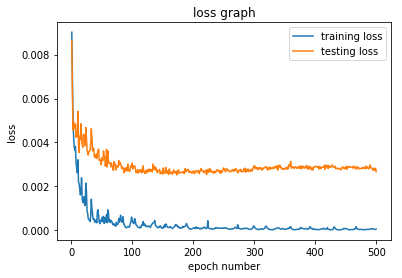

In [9]:
x = range(1, epoch_num+1)

plt.plot(x, loss1, label="training loss")
plt.plot(x, loss2, label="testing loss")
plt.xlabel("epoch number")
#plt.xticks(np.linspace(1,epoch_num,epoch_num))
plt.ylabel("loss")
plt.title("loss graph")
plt.legend()
plt.savefig("./coordinate-regression-loss.jpg")
plt.show()

In [ ]:
torch.save(net, '/disk1/jklu/models/shallow.pth')

In [10]:
def CVimshow2pltimshow(cv_img):
    """
    cv_img: [3, height, width], BGR, numpy array, int(0-255)
    """
    b,g,r = cv.split(cv_img)  
    plt_img = cv.merge([r,g,b]).astype(np.int)
    return plt_img

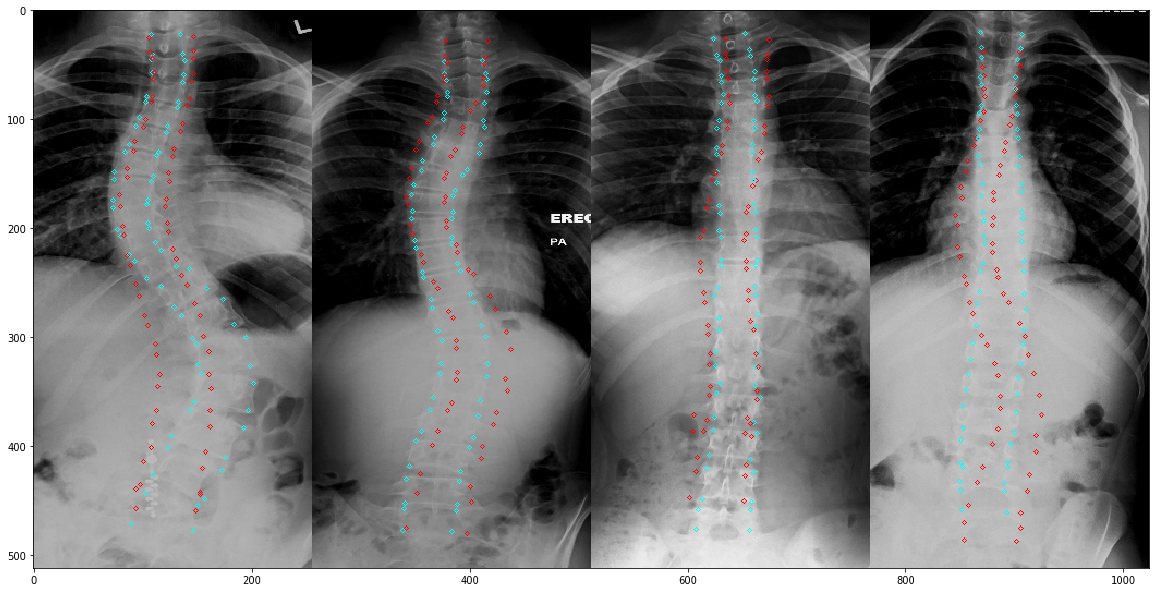

In [16]:
# visualize result
# note: opencv will take image as BGR but plt.imshow will take as RGB. 
# plt.show need int for 0-255 scale or float for 0-1 scale at each pixel

import matplotlib as mpl
mpl.rcParams['figure.figsize'] = (20, 20)

dataiter = iter(test_loader)
images, labels = dataiter.next()
batch, channel, height, width = images.shape
# note: images.shape = (batch, channel, width, height)

ret = net(images.to(device))

batch_img = np.zeros((height, width * batch, 3), np.int)

for i in range(batch):
    sample = images[i].numpy().squeeze(0)
    sample_BGR = cv.cvtColor(sample, cv.COLOR_GRAY2BGR)

    label = labels[i]
    predict = ret[i]

    point_num = len(label) // 2
    for j in range(point_num):
        cv.circle(sample_BGR, (int(label[j] * width), int(label[j + point_num]* height)), 2, (255, 255, 0))
        cv.circle(sample_BGR, (int(predict[j] * width), int(predict[j + point_num]* height)), 2, (0, 0, 255))
        
    plt_img = CVimshow2pltimshow(sample_BGR)
    batch_img[:, i * width:(i+1) * width, :] = plt_img
    
    
plt.imshow(batch_img)
